### pyVHR implementation for CPU architecture

In [8]:
#Reference: 
#pyVHR: a Python framework for remote photoplethysmography
#Giuseppe Boccignone, Donatello Conte, Vittorio Cuculo, Alessandro D’Amelio, Giuliano Grossi, Raffaella Lanzarotti and 
#Edoardo Mortara

Run the following code to obtain BPM estimates over time for a single video


Processing Video: vid.avi


d:\Techlabs\pyvhr\pyvhr-env\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '



BVP extraction with method: cpu_POS

BPM estimation with: welch

...done!



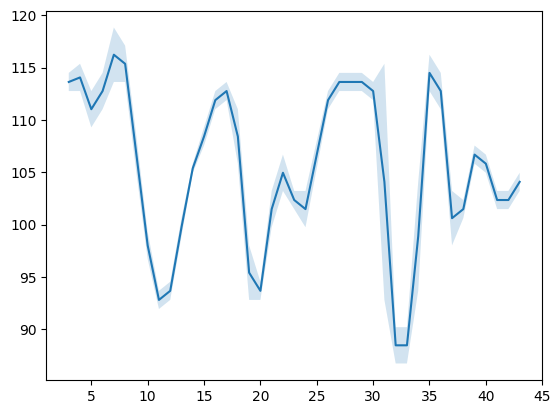

In [9]:
from pyVHR.analysis.pipeline import Pipeline
import matplotlib.pyplot as plt

pipe = Pipeline()
time, BPM, uncertainty = pipe.run_on_video('vid.avi', roi_approach="patches", roi_method="convexhull")

plt.figure()
plt.plot(time, BPM)
plt.fill_between(time, BPM-uncertainty, BPM+uncertainty, alpha=0.2)
plt.show()

Estimation of BPM from a video input - Includes necessary intermediate steps mentioned in pyVHR package

In [10]:
from pyVHR.extraction.sig_processing import SignalProcessing
from pyVHR.extraction.skin_extraction_methods import SkinExtractionFaceParsing
from pyVHR.extraction.skin_extraction_methods import SkinExtractionConvexHull
from pyVHR.extraction.utils import MagicLandmarks
from pyVHR.extraction.utils import sig_windowing, get_fps
from pyVHR.BVP.methods import cpu_POS, cpu_GREEN
from pyVHR.BVP.BVP import RGB_sig_to_BVP
from pyVHR.BVP.BVP import signals_to_bvps_cpu
from pyVHR.BVP.filters import apply_filter
from pyVHR.BVP.filters import detrend
from pyVHR.BVP.filters import BPfilter
from pyVHR.BPM.BPM import BVP_to_BPM, multi_est_BPM_median
import matplotlib.pyplot as plt

skin_method = 'convexhull' #Skin extraction method
target_device ='CPU'
videoFileName = 'vid.avi'  #Video file for bpm estimnation

sig_processing = SignalProcessing ()

if skin_method == 'convexhull':
    sig_processing.set_skin_extractor(SkinExtractionConvexHull())
elif skin_method == 'faceparsing':
    sig_processing.set_skin_extractor(SkinExtractionFaceParsing())

#---Holistic approach
#sig = sig_processing.extract_holistic(videoFileName)

#---Patch-based appraoch
ldmks_list = [MagicLandmarks.cheek_left_top[16], MagicLandmarks.cheek_right_top[14],
              MagicLandmarks.forehead_center[1]]  #Landmarks points maintained in pyVHR referred from mediapipe
sig_processing.set_landmarks(ldmks_list)
# set squares patches side dimension
sig_processing.set_square_patches_side(28.0)
# Extract square patches and compute the RGB trajectories as the channel - wise mean
#Returns a 3d array of shape [num_frames, num_patches, rgb_channels] - patches are the ROIs from face
sig = sig_processing.extract_patches(videoFileName, 'squares', 'mean') 

#---Pre-processing(if needed)
#filtered_sig = apply_filter(sig , detrend)

#---Signal computation based on overlapping windows
Ws = 6 # window length in seconds
overlap = 1 # window overlap in seconds
fps = get_fps(videoFileName)
#Returns a a list of length num_windows of array with shape [num_estimators(num_patches), rgb_channels, window_frames], 
#and a 1D ndarray of times in seconds,where each one is the center of a window.
windowed_sig, timesES = sig_windowing(sig, Ws, overlap, fps) 

#---BVP estimation from RGB signals
#Returns a list of length num_windows of BVP signals as array with shape [num_estimators, num_frames]
bvp = RGB_sig_to_BVP(windowed_sig, fps, device_type ='cpu', method = cpu_POS, params={'fps':'adaptive'})

#--Post-processing(if needed)
#filtered_bvp = apply_filter(bvp, BPfilter, params ={'order':6, 'minHz':0.65, 'maxHz':14.0, 'fps': fps})

#---BPM estimation
#Returns a list of length num_windows of BPM signals with shape [num_estimators, ]
bpmES = BVP_to_BPM(bvp, fps, minHz = 0.65, maxHz = 14.0)
# median BPM from multiple estimators BPM
bpm , uncertainty = multi_est_BPM_median(bpmES)


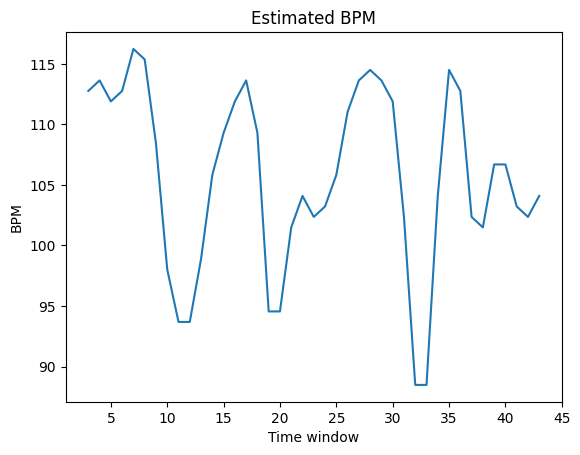

In [11]:
#Plot the estimated BPM 
plt.figure()
plt.title("Estimated BPM")
plt.xlabel("Time window")
plt.ylabel("BPM")
plt.plot(timesES, bpm)
plt.show()

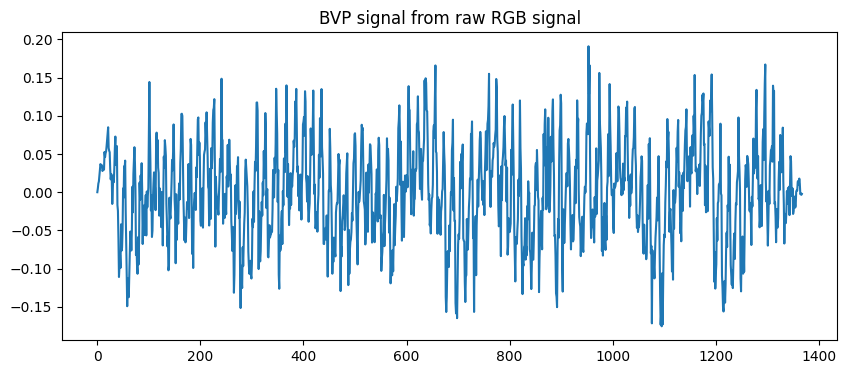

In [12]:
#---Function to extract BPV directly from the RGB signal (no overlapping windows)
import numpy as np

sig_trans = np.transpose(sig,(1,2,0)) # Input - array with shape [num_estimators, rgb_channels, num_frames]

#Input - array with shape [rgb_channels, num_frames, num_estimators]
#Returns BVP signal as float32 ndarray with shape [num_estimators, num_frames]
bvps = signals_to_bvps_cpu(sig_trans, cpu_POS, params={'fps':fps})

#Calculate the BPM across all channels by estimating the mean/median
bvps_mean = np.median(bvps, axis=0)
#print(bvps_mean.shape)
plt.figure(figsize=(10,4))
plt.title("BVP signal from raw RGB signal")
plt.plot(bvps_mean)
plt.show()
